# Preparing the Dataset
In this section, we will prepare the dataset given by the data engineer.  
The dataset is split with a 4:1 ratio, 4 parts for training data, and 1 part for validation data.

In [1]:
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator

dataset = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = dataset.flow_from_directory(
    "dataset",
    target_size=(256, 256),
    class_mode="categorical",
    subset="training"
)

validation_data = dataset.flow_from_directory(
    "dataset",
    target_size=(256, 256),
    class_mode="categorical",
    subset="validation"
)

2025-01-16 02:59:23.928257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736967564.128440  136588 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736967564.174936  136588 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-16 02:59:24.460617: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 8111 images belonging to 5 classes.
Found 2027 images belonging to 5 classes.


# Compiling/Training the Model
The model will now be compiled, this model has additional layers such as `RandomRotation` and `RandomZoom` as additional data augmentation to ensure that the model is trained to predict images even when they are slightly rotated or zoomed in.

In [11]:
from tensorflow import keras
from keras.api.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, RandomRotation, RandomZoom, BatchNormalization

model = keras.Sequential([
    Input((256, 256, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
    Conv2D(64, (3, 3), activation='leaky_relu'),
    MaxPooling2D((3, 3)),
    Conv2D(32, (3, 3), activation='leaky_relu'),
    MaxPooling2D((2, 2)),
    Conv2D(16, (3, 3), activation='leaky_relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, kernel_regularizer="l2", activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In the code block below, we also use `ReduceLROnPlateau`. This model fitting callback instructs the training system to reduce the learning rate of the model so that the validation accuracy is similar to the training accuracy.

In [17]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

history = model.fit(
    train_data,
    epochs=10,
    validation_data=validation_data,
    validation_steps=50,  # Number of validation batches,
    callbacks=[reduce_lr]
)

Epoch 1/10


2025-01-16 03:37:33.463859: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,256,256]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-16 03:37:33.593965: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,256,256]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAct

171/254 ━━━━━━━━━━━━━━━━━━━━ 37s 449ms/step - accuracy: 0.5058 - loss: 2.3082

2025-01-16 03:39:14.175668: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,3,256,256]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-16 03:39:14.359891: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,64,256,256]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAct

254/254 ━━━━━━━━━━━━━━━━━━━━ 194s 641ms/step - accuracy: 0.5430 - loss: 1.9444 - val_accuracy: 0.8100 - val_loss: 0.5425 - learning_rate: 0.0010
Epoch 2/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 134s 527ms/step - accuracy: 0.7710 - loss: 0.6011 - val_accuracy: 0.8631 - val_loss: 0.4002 - learning_rate: 0.0010
Epoch 3/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 132s 517ms/step - accuracy: 0.8142 - loss: 0.4893 - val_accuracy: 0.8569 - val_loss: 0.3890 - learning_rate: 0.0010
Epoch 4/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 141s 553ms/step - accuracy: 0.8128 - loss: 0.4560 - val_accuracy: 0.8763 - val_loss: 0.3894 - learning_rate: 0.0010
Epoch 5/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 151s 590ms/step - accuracy: 0.8474 - loss: 0.3791 - val_accuracy: 0.8900 - val_loss: 0.3350 - learning_rate: 0.0010
Epoch 6/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 201s 792ms/step - accuracy: 0.8694 - loss: 0.3202 - val_accuracy: 0.8850 - val_loss: 0.3477 - learning_rate: 0.0010
Epoch 7/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 148s 576ms/step - accuracy: 0.8695 

We will now save the model with the filename `categorical1.keras`.

In [18]:
model.save("categorical1.keras")

# Validating Model for Overfitting/Underfitting
In the code below, we will check for the training and validation accuracy.  
Throughout the training session, we noticed that the validation accuracy was able to keep up with the training accuracy. This is further confirmed by the graph shown below as the final validation accuracy was not too far off from the training accuracy towards the end of the training session.

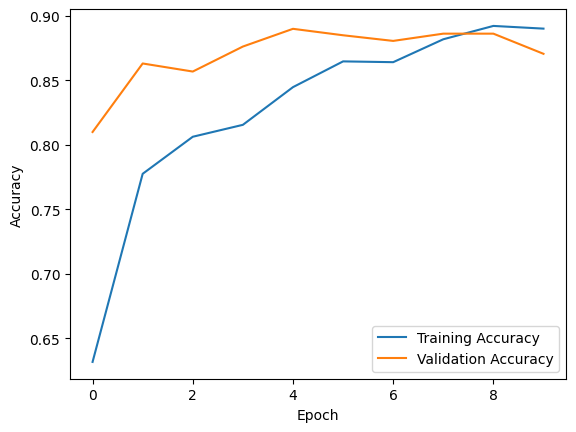

In [19]:
import matplotlib.pyplot as plt

# Get the plot of the training accuracy and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Validating the Model Against Real Data
This section covers validating the model for it's accuracy when data is cherry picked for verification of the model's predictions.  
As shown below, the model was able to attain 80% accuracy with the model being able to get 70-100% accuracy on multiple runs of testing.

{'Brassavola': 0, 'Masdevallia': 1, 'Paphiopedilum Bellatulum': 2, 'Paphiopedilum Charlesworthii': 3, 'Phalaenopsis': 4}
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


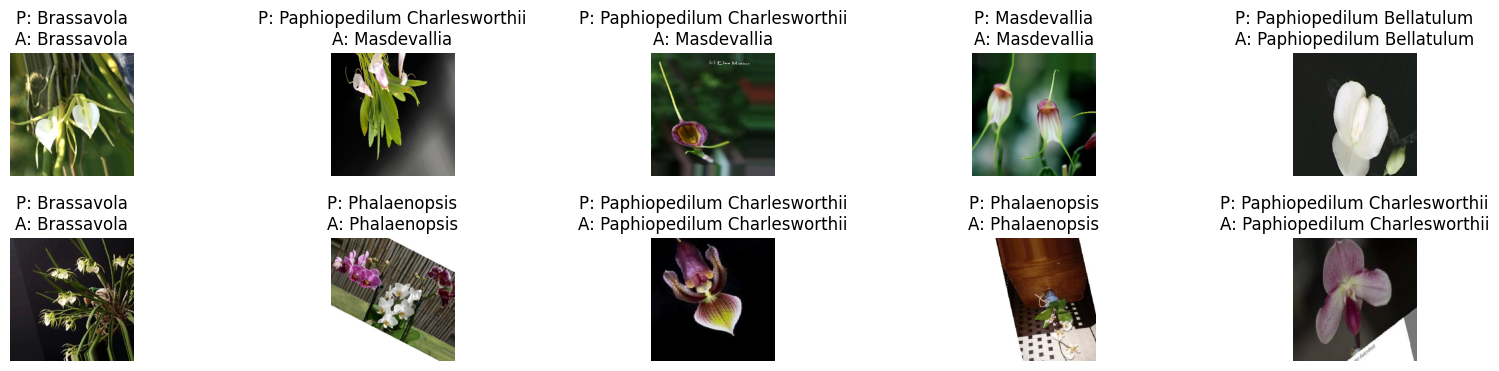

80.0%


In [33]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

# Load the model
model = load_model("categorical1.keras")

# Choose a few random samples from the validation set
num_samples_to_display = 10
sample_indices = np.random.choice(len(validation_data), num_samples_to_display, replace=False)
count = 0
print(validation_data.class_indices)

# Create a function for showing the subspecies of the orchid
def getClassLabel(index: int):
    indices = validation_data.class_indices
    for key in list(indices.keys()):
        if indices[key] == index:
            return key

# Display the samples and their predicted and actual labels
fig, axes = plt.subplots(2, int(num_samples_to_display / 2), figsize=(20, 4))
plt.subplots_adjust(hspace=0.5)
for i, ax in enumerate(axes.flat):
    sample_index = sample_indices[i]
    image, label = validation_data[sample_index]
    
    # Extract individual image from batch
    image = image[0]
    
    # Make prediction using the model
    prediction = model.predict(np.expand_dims(image, axis=0))
    predicted_label = np.argmax(prediction[0])
    
    ax.imshow(image)
    ax.set_title(f"P: {getClassLabel(predicted_label)}\nA: {getClassLabel(np.argmax(label[0]))}")
    ax.axis('off')
    if predicted_label == np.argmax(label[0]):
        count += 1

plt.show()
print(f"{(count/10) * 100}%")

For the code below, we have taken some few images from the internet as to ensure some randomness is taken into account during the validation tests.  
As is what's shown below, the above situation also applies here as the model was able to achieve 70-100% accuracy, with the one below showing a 90% accuracy.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


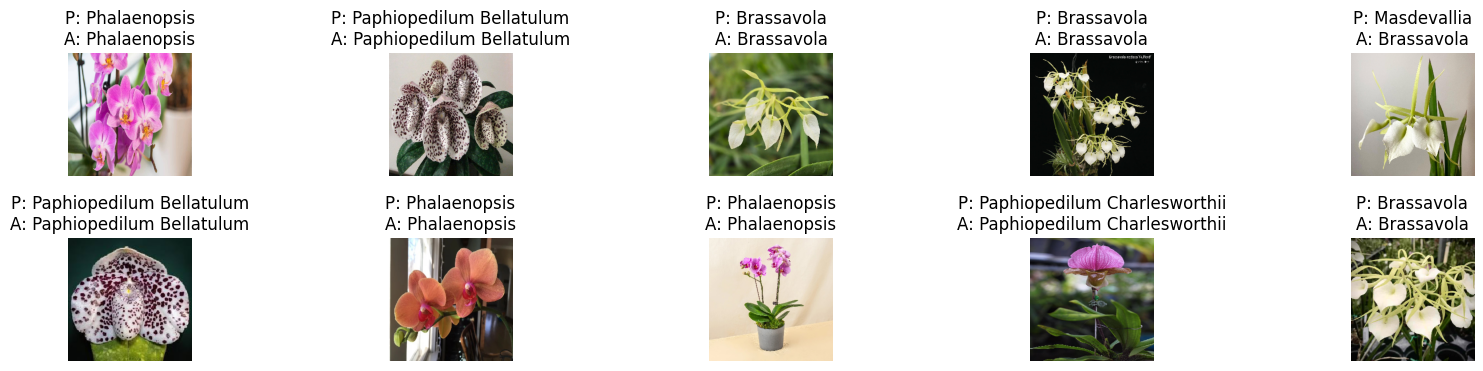

90.0%


In [36]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing import image

# Define the variables needed for this code block
indices = {'Brassavola': 0, 'Masdevallia': 1, 'Paphiopedilum Bellatulum': 2, 'Paphiopedilum Charlesworthii': 3, 'Phalaenopsis': 4}
folder_path = "testing-data"

# Get the list of image file names
image_files = os.listdir(folder_path)

# Choose a few random samples from the folder
num_samples_to_display = 10
sample_indices = np.random.choice(len(image_files), num_samples_to_display, replace=False)
count = 0

# Create a function for showing the subspecies of the orchid
def getClassLabel(index: int):
    for key in list(indices.keys()):
        if indices[key] == index:
            return key

# Display the samples and their predicted and actual labels
fig, axes = plt.subplots(2, int(num_samples_to_display / 2), figsize=(20, 4))
plt.subplots_adjust(hspace=0.5)
for i, ax in enumerate(axes.flat):
    sample_index = sample_indices[i]
    file_name = image_files[sample_index]
    img_path = os.path.join(folder_path, file_name)
    species_name = file_name.split(".")[0]
    
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make prediction using the model
    prediction = model.predict(img_array)
    predicted_label = np.argmax(prediction[0])
    
    ax.imshow(img)
    ax.set_title(f"P: {getClassLabel(predicted_label)}\nA: {species_name}")
    ax.axis('off')
    if getClassLabel(predicted_label) == species_name:
        count += 1

plt.show()
print(f"{(count/10) * 100}%")